In [1]:
# !pip install gspread

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from tabulate import tabulate
from itertools import combinations
import seaborn as sns


In [ ]:
import gspread
from google.colab import auth
from google.auth import default
auth.authenticate_user()
creds, _ = default()
client = gspread.authorize(creds)


## Utils


In [ ]:
from itertools import combinations
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def generate_cooccurrence_heatmap(
    data_column,
    remove_empty=True,
    normalize='row',  # Accepts None, 'row', 'jaccard', 'pmi'
    round=False,
    save_path=None
):
    # Extract and clean labels
    codellama_categories = (
        data_column.dropna()
        .astype(str)
        .apply(lambda x: x.split(","))
        .to_list()
    )

    if remove_empty:
        codellama_categories = [
            [label.strip() for label in sublist if label.strip() != ""]
            for sublist in codellama_categories
        ]
    else:
        codellama_categories = [
            [label.strip() for label in sublist] for sublist in codellama_categories
        ]

    # Count co-occurrences
    codellama_pair_counter = Counter()
    for labels in codellama_categories:
        unique_labels = sorted(set(labels))
        for pair in combinations(unique_labels, 2):
            codellama_pair_counter[pair] += 1

    # Get unique labels and total instances
    labels = sorted(set(label for sublist in codellama_categories for label in sublist if label))
    T = len(codellama_categories)  # Total instances

    # Create matrix and populate counts
    co_occurrence_matrix = pd.DataFrame(0, index=labels, columns=labels)
    for (label1, label2), count in codellama_pair_counter.items():
        co_occurrence_matrix.at[label1, label2] = count
        co_occurrence_matrix.at[label2, label1] = count  # Symmetric

    # Normalize if requested
    if normalize:
        # Calculate label frequencies
        label_counts = {label: 0 for label in labels}
        for sublist in codellama_categories:
            for label in sublist:
                label_counts[label] += 1

        # Apply normalization
        normalized_matrix = pd.DataFrame(0.0, index=labels, columns=labels)
        for i in labels:
            for j in labels:
                count_ij = co_occurrence_matrix.at[i, j]
                if normalize == 'row':
                    norm_val = count_ij / label_counts[i] if label_counts[i] != 0 else 0
                elif normalize == 'jaccard':
                    denom = label_counts[i] + label_counts[j] - count_ij
                    norm_val = count_ij / denom if denom != 0 else 0
                elif normalize == 'pmi':
                    p_i = label_counts[i] / T
                    p_j = label_counts[j] / T
                    p_ij = count_ij / T
                    if p_i == 0 or p_j == 0 or p_ij == 0:
                        norm_val = 0
                    else:
                        norm_val = np.log(p_ij / (p_i * p_j))
                normalized_matrix.at[i, j] = norm_val

        co_occurrence_matrix = normalized_matrix

    # Round values if needed
    if round:
        co_occurrence_matrix = co_occurrence_matrix.round(2)

    # Plotting
    plt.figure(figsize=(8, 6))
    fmt = ".2f" if normalize else "d"
    cmap = "RdBu" if normalize == 'pmi' else "Blues"
    sns.heatmap(
        co_occurrence_matrix,
        annot=True,
        cmap=cmap,
        fmt=fmt,
        center=0 if normalize == 'pmi' else None
    )
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Heatmap saved at {save_path}")
    else:
        plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

def generate_cooccurrence_heatmap(data_column, remove_empty=True, normalize=True, save_path=None):
    # Extract labels and split them properly
    codellama_categories = (
        data_column.dropna()
        .astype(str)
        .apply(lambda x: x.split(","))
        .to_list()
    )

    # Ensure labels are stripped of whitespace and remove empty labels if needed
    if remove_empty:
        codellama_categories = [
            [label.strip() for label in sublist if label.strip() != ""] for sublist in codellama_categories
        ]
    else:
        codellama_categories = [[label.strip() for label in sublist] for sublist in codellama_categories]

    # Initialize Counter to store co-occurrence counts
    codellama_pair_counter = Counter()

    # Count label co-occurrences
    for labels in codellama_categories:
        labels = sorted(set(labels))  # Ensure unique labels per row
        for pair in combinations(labels, 2):  # Generate all label pairs
            codellama_pair_counter[pair] += 1  # Increment count

    # Extract unique labels (excluding empty labels if needed)
    labels = sorted(set(label for sublist in codellama_categories for label in sublist if label != ""))

    # Create an empty co-occurrence matrix
    co_occurrence_matrix = pd.DataFrame(0, index=labels, columns=labels)

    # Fill the matrix with counts
    for (label1, label2), count in codellama_pair_counter.items():
        co_occurrence_matrix.at[label1, label2] = count
        co_occurrence_matrix.at[label2, label1] = count  # Mirror for symmetry

    # Normalize across rows if required
    if normalize:
        co_occurrence_matrix = co_occurrence_matrix.div(co_occurrence_matrix.sum(axis=1), axis=0).fillna(0)
        # pd.set_option('display.float_format', lambda x: f'{x:.2f}' if x != 0 else f'.{x:.2f}'[1:])


    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(co_occurrence_matrix, annot=True, cmap="Blues", fmt=".2f" if normalize else "d")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    # Save the heatmap if save_path is provided
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')  # Save as PDF
        print(f"Heatmap saved at {save_path}")
    else:
        plt.show()


# Analysis
- frequency [done]
- heat map for co-occurence [done]
- how many are efficient
- how many have more than one category

In [ ]:
file_id = ""
ineff_Eval = pd.DataFrame(client.open_by_key(file_id).sheet1.get_all_records())
ineff_Eval.head()

In [ ]:
codellama_categories = []
for x in ineff_Eval['codellama_category'].to_list():
  codellama_categories.extend([y.strip() for y in x.split(',') if y])
codellama_categories_counter =  Counter(codellama_categories)

deepseeker_categories = []
for x in ineff_Eval['deepseek_category'].to_list():
  deepseeker_categories.extend([y.strip() for y in x.split(',') if y])
deepseeker_categories_counter =  Counter(deepseeker_categories)

codegemma_categories = []
for x in ineff_Eval['codegemma_category'].to_list():
  codegemma_categories.extend([y.strip() for y in x.split(',') if y])
codegemma_categories_counter =  Counter(codegemma_categories)



all_models_categories_counter = codellama_categories_counter + deepseeker_categories_counter + codegemma_categories_counter

print("## codellama categories")
print(codellama_categories_counter)
print("## deepseeker categories")
print(deepseeker_categories_counter)
print("## codegemma categories")
print(codegemma_categories_counter)

print("## all models categories")
print(all_models_categories_counter)

## codellama categories
Counter({'1-General Logic': 99, '2-Performance': 80, '5-Maintainabiliy': 49, '4-Errors': 12, '3-Readability': 11})
## deepseeker categories
Counter({'1-General Logic': 116, '2-Performance': 50, '5-Maintainabiliy': 21, '3-Readability': 10, '4-Errors': 10})
## codegemma categories
Counter({'1-General Logic': 122, '2-Performance': 38, '5-Maintainabiliy': 34, '4-Errors': 6, '3-Readability': 2})
## all models categories
Counter({'1-General Logic': 337, '2-Performance': 168, '5-Maintainabiliy': 104, '4-Errors': 28, '3-Readability': 23})


In [ ]:
codellama_subcategories = []
for x in ineff_Eval['codellama_sub_category'].to_list():
  codellama_subcategories.extend([y.strip() for y in x.split(',') if y])
codellama_subcategories_counter =  Counter(codellama_subcategories)

deepseek_subcategories = []
for x in ineff_Eval['deepseek_sub_category'].to_list():
  deepseek_subcategories.extend([y.strip() for y in x.split(',') if y])
deepseek_subcategories_counter =  Counter(deepseek_subcategories)

codegemma_subcategories = []
for x in ineff_Eval['codegemma_sub_category'].to_list():
  codegemma_subcategories.extend([y.strip() for y in x.split(',') if y])
codegemma_subcategories_counter =  Counter(codegemma_subcategories)

all_models_subcategories_counter = codellama_subcategories_counter + deepseek_subcategories_counter + codegemma_subcategories_counter


codellama_subcategories_counter = dict(sorted(codellama_subcategories_counter.items()))
deepseek_subcategories_counter = dict(sorted(deepseek_subcategories_counter.items()))
codegemma_subcategories_counter = dict(sorted(codegemma_subcategories_counter.items()))
all_models_subcategories_counter = dict(sorted(all_models_subcategories_counter.items()))

# print("## codellama subcategories")
# print(tabulate(codellama_subcategories_counter.items(), tablefmt='grid'))
# print("## deepseeker subcategories")
# print(tabulate(deepseek_subcategories_counter.items(), tablefmt='grid'))
# print("## codegemma subcategories")
# print(tabulate(codegemma_subcategories_counter.items(), tablefmt='grid'))

# print("## all models subcategories")
# print(tabulate(all_models_subcategories_counter.items(), tablefmt='grid'))

In [ ]:
deepseeker_categories = ineff_Eval['deepseek_category']
codegemma_categories = ineff_Eval['codegemma_category']
codellama_categories = ineff_Eval['codellama_category']
all_categories = pd.concat([deepseeker_categories, codegemma_categories, codellama_categories], axis=0)



Heatmap saved at codellama_heatmap.pdf
Heatmap saved at deepseeker_heatmap.pdf
Heatmap saved at codegemma_heatmap.pdf
Heatmap saved at all_categories_heatmap.pdf


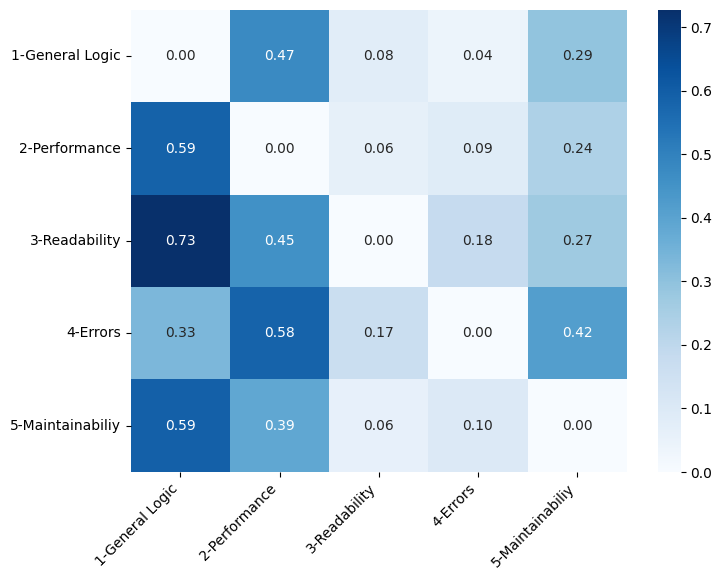

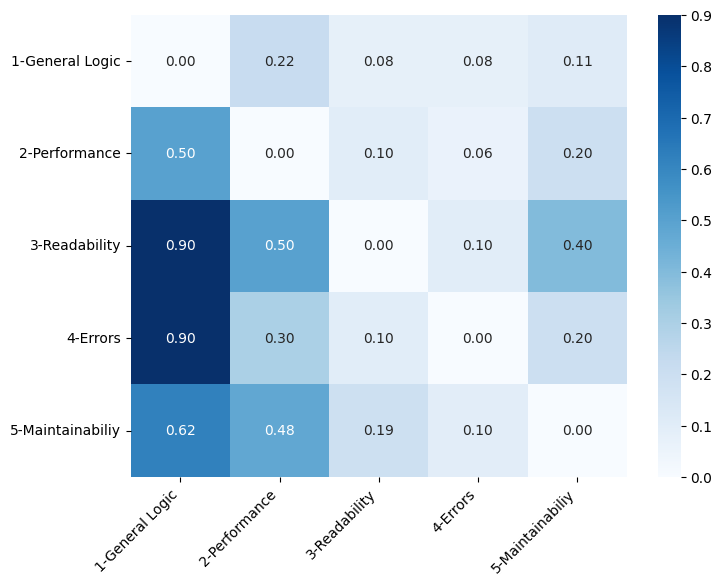

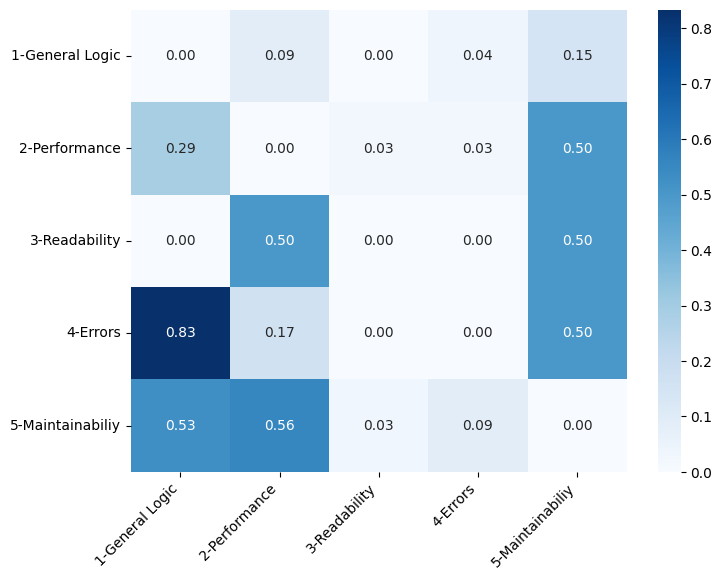

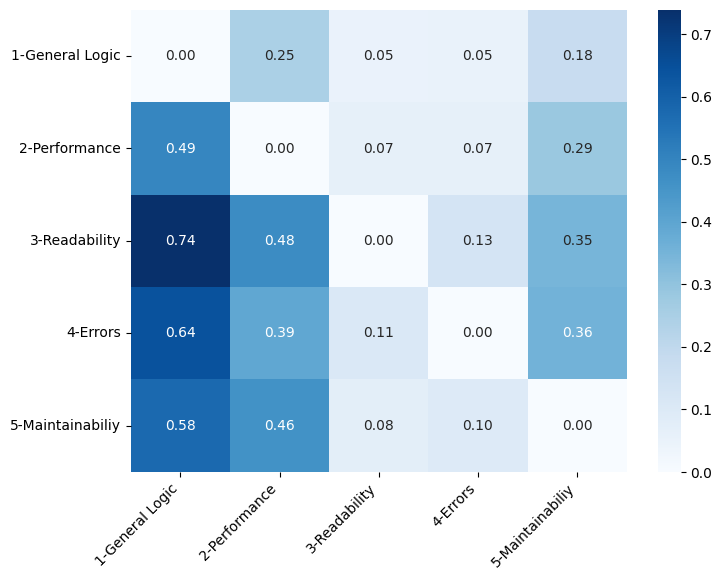

In [ ]:
generate_cooccurrence_heatmap(codellama_categories, save_path="codellama_heatmap.pdf")
generate_cooccurrence_heatmap(deepseeker_categories, save_path="deepseeker_heatmap.pdf")
generate_cooccurrence_heatmap(codegemma_categories, save_path="codegemma_heatmap.pdf")
generate_cooccurrence_heatmap(all_categories, save_path="all_categories_heatmap.pdf")

Heatmap saved at codellama_subcategories_heatmap.pdf
Heatmap saved at deepseeker_subcategories_heatmap.pdf
Heatmap saved at codegemma_subcategories_heatmap.pdf
Heatmap saved at all_subcategories_heatmap.pdf


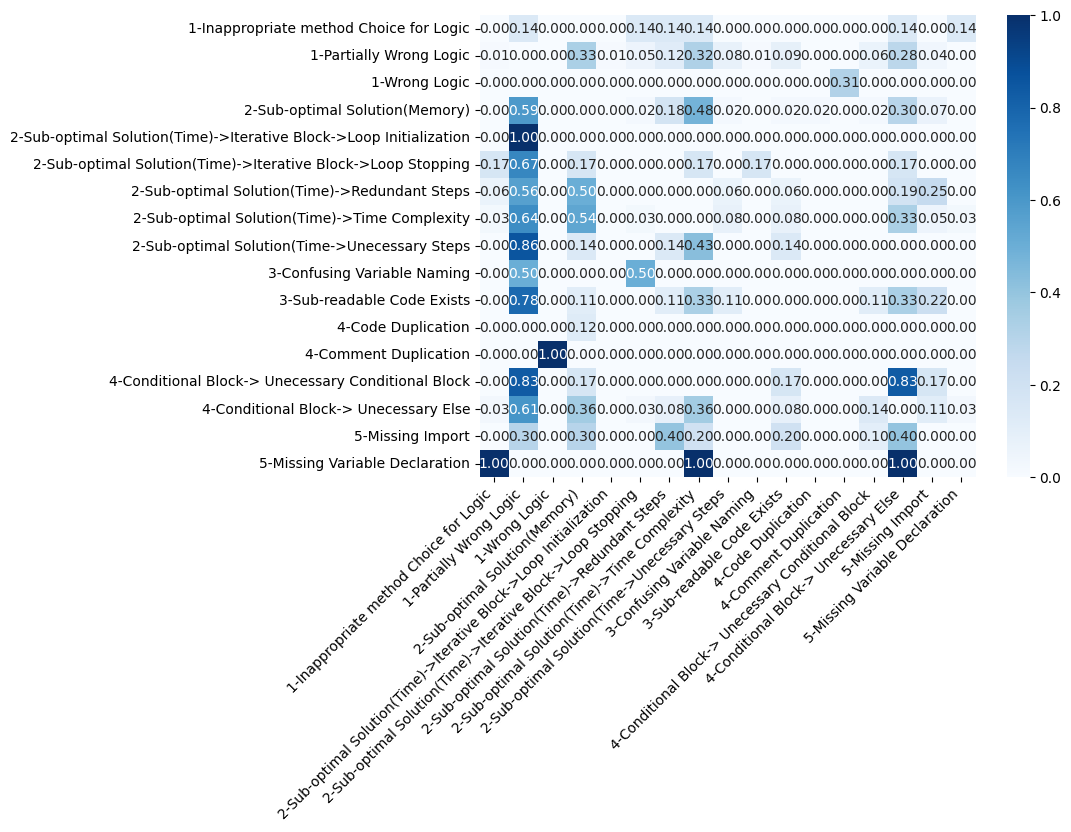

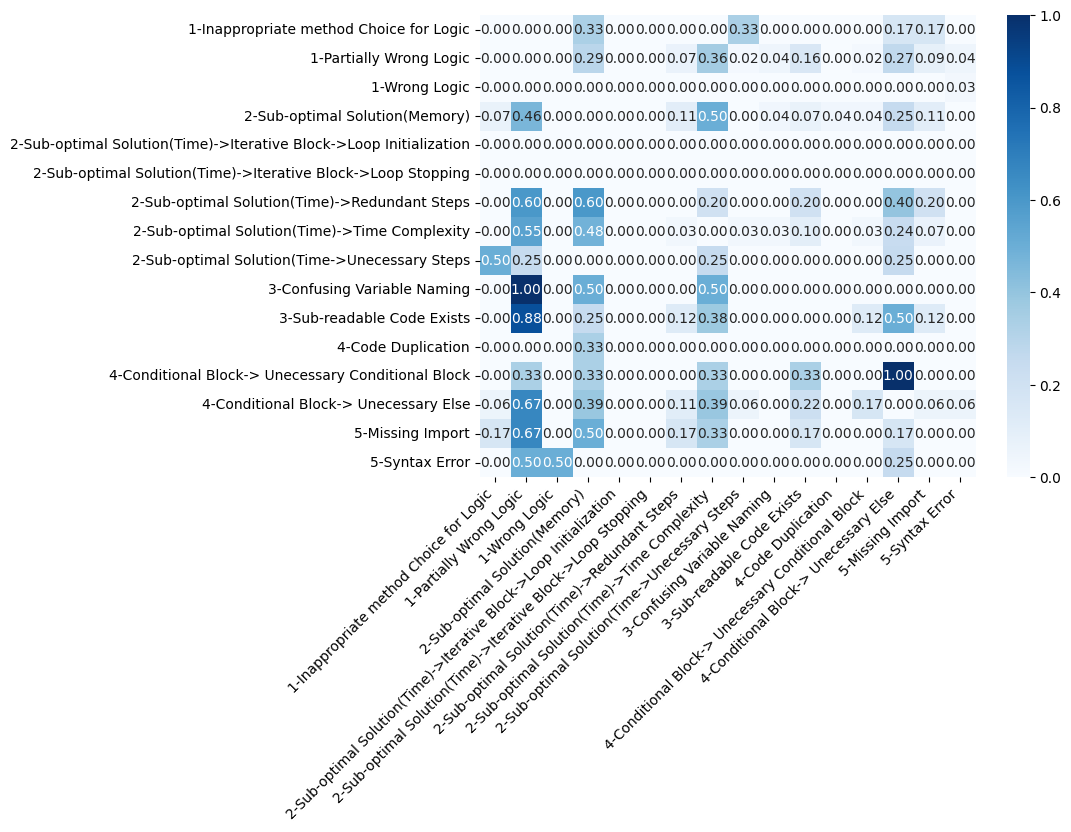

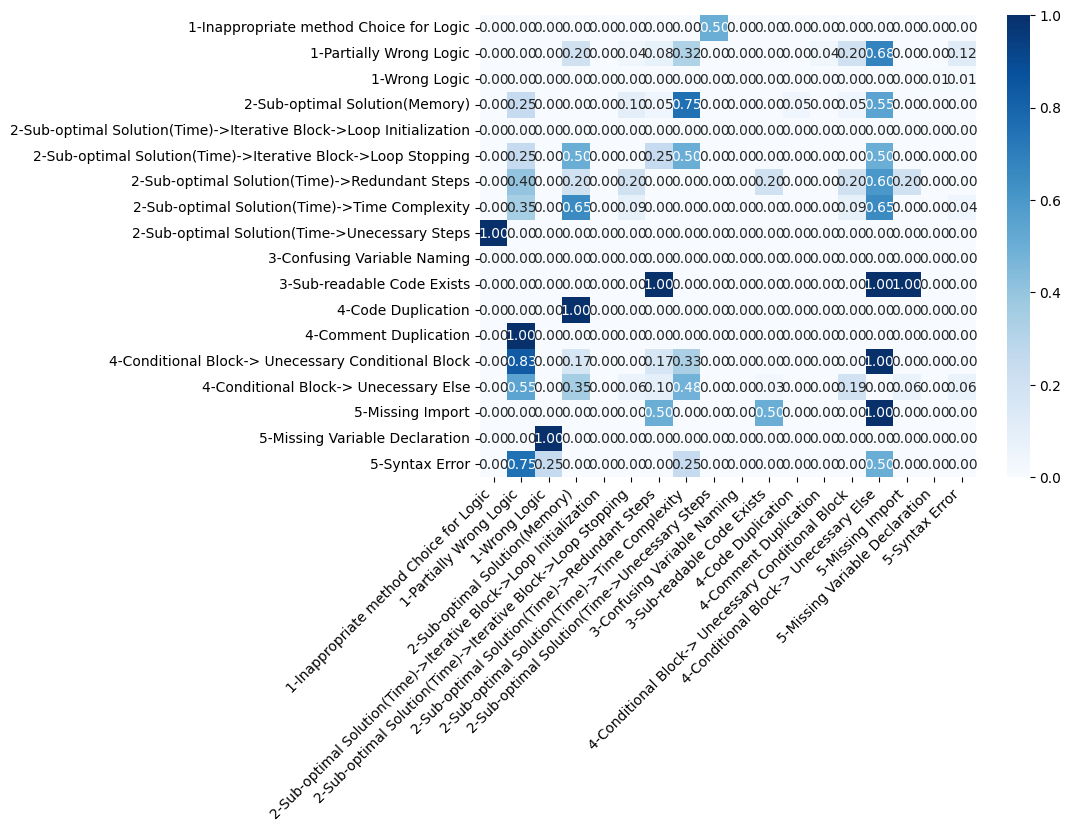

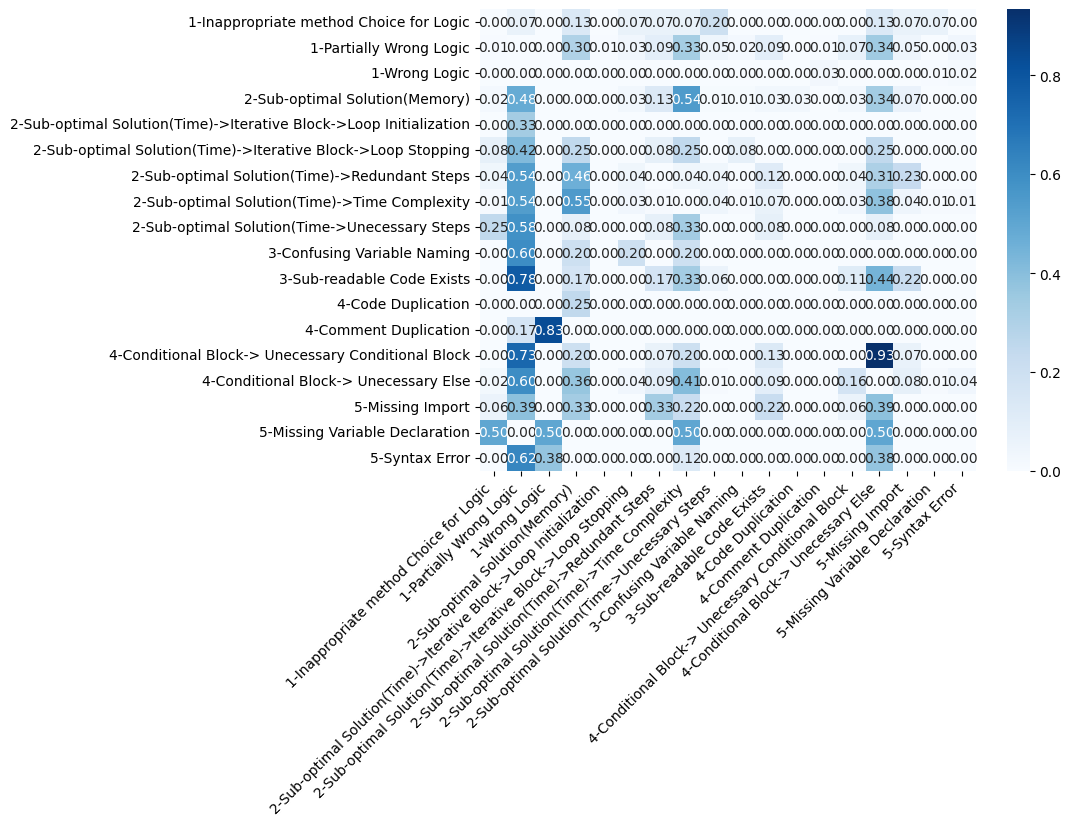

In [ ]:
deepseek_subcategories = ineff_Eval['deepseek_sub_category']
codegemma_subcategories = ineff_Eval['codegemma_sub_category']
codellama_subcategories = ineff_Eval['codellama_sub_category']
all_subcategories = pd.concat([deepseek_subcategories, codegemma_subcategories, codellama_subcategories], axis=0)

generate_cooccurrence_heatmap(codellama_subcategories, save_path="codellama_subcategories_heatmap.pdf")
generate_cooccurrence_heatmap(deepseek_subcategories, save_path="deepseeker_subcategories_heatmap.pdf")
generate_cooccurrence_heatmap(codegemma_subcategories, save_path="codegemma_subcategories_heatmap.pdf")
generate_cooccurrence_heatmap(all_subcategories, save_path="all_subcategories_heatmap.pdf")

In [ ]:
## how many of the codes are efficient and how many categories we have (the rate of multi labeling)
n_deepseeker_categories_counter = Counter([len(x.split(',')) if x.strip() != '' else 0 for x in ineff_Eval['deepseek_category']])
n_codegemma_categories_counter = Counter([len(x.split(','))  if x.strip()!='' else 0 for x in ineff_Eval['codegemma_category']])
n_codellama_categories_counter = Counter([len(x.split(','))  if x.strip()!='' else 0 for x in ineff_Eval['codellama_category']])
n_all_categories_counter = n_deepseeker_categories_counter + n_codegemma_categories_counter + n_codellama_categories_counter

print("## codellama categories")
print(n_codellama_categories_counter)
print("## deepseeker categories")
print(n_deepseeker_categories_counter)
print("## codegemma categories")
print(n_codegemma_categories_counter)

print("## all categories")
print(n_all_categories_counter)


## codellama categories
Counter({1: 68, 2: 60, 3: 17, 0: 16, 4: 2, 5: 1})
## deepseeker categories
Counter({1: 102, 2: 29, 0: 18, 3: 14, 5: 1})
## codegemma categories
Counter({1: 108, 2: 32, 0: 15, 3: 6, 4: 3})
## all categories
Counter({1: 278, 2: 121, 0: 49, 3: 37, 4: 5, 5: 2})


In [ ]:
n_deepseeker_sub_categories_counter = Counter([len(x.split(','))  if x.strip()!='' else 0 for x in ineff_Eval['deepseek_sub_category']])
n_codegemma_sub_categories_counter = Counter([len(x.split(','))  if x.strip()!='' else 0 for x in ineff_Eval['codegemma_sub_category']])
n_codellama_sub_categories_counter = Counter([len(x.split(','))  if x.strip()!='' else 0 for x in ineff_Eval['codellama_sub_category']])
n_all_sub_categories_counter = n_deepseeker_sub_categories_counter + n_codegemma_sub_categories_counter + n_codellama_sub_categories_counter

print("## codellama subcategories")
print(n_codellama_sub_categories_counter)
print("## deepseeker subcategories")
print(n_deepseeker_sub_categories_counter)
print("## codegemma subcategories")
print(n_codegemma_sub_categories_counter)

print("## all subcategories")
print(n_all_sub_categories_counter)

## codellama subcategories
Counter({1: 64, 2: 40, 3: 31, 0: 16, 4: 11, 6: 1, 5: 1})
## deepseeker subcategories
Counter({1: 96, 2: 30, 0: 18, 3: 10, 4: 8, 6: 1, 5: 1})
## codegemma subcategories
Counter({1: 106, 2: 20, 0: 15, 3: 15, 4: 7, 5: 1})
## all subcategories
Counter({1: 266, 2: 90, 3: 56, 0: 49, 4: 26, 5: 3, 6: 2})
